In [1]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
import sklearn
import cv2
from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns
import datetime
import io
from PIL import Image
import albumentations as A
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, InputLayer, BatchNormalization, Input, Dropout, RandomFlip, RandomRotation
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, CSVLogger, EarlyStopping, LearningRateScheduler, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import L1,L2

# import wandb
# from wandb import WandbCallback


In [2]:
!pip install -q kaggle

In [3]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

cp: cannot stat 'kaggle.json': No such file or directory


In [4]:
!chmod 600 /root/.kaggle/kaggle.json


chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [5]:
!kaggle datasets download -d muhammadhananasghar/human-emotions-datasethes

Dataset URL: https://www.kaggle.com/datasets/muhammadhananasghar/human-emotions-datasethes
License(s): unknown
 94% 290M/309M [00:01<00:00, 207MB/s]
100% 309M/309M [00:01<00:00, 221MB/s]


In [6]:
!unzip "/content/human-emotions-datasethes.zip" -d "/content/dataset/"

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/EmotionsDataset/data/nothing/720.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/721.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/722.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/723.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/724.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/725.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/726.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/727.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/728.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/729.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/73.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/730.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/731.jpg  
  inflating: /content/dataset/EmotionsDataset/data/no

Dataset Loading

In [66]:
train_directory = "/content/dataset/Emotions Dataset/Emotions Dataset/train"
validation_directory = "/content/dataset/Emotions Dataset/Emotions Dataset/test"
CLASS_NAMES = ["angry", "happy","sad" ]

CONFIGURATION = {
    "BATCH_SIZE" : 32,
    "IM_SIZE": 224,

}

In [67]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_directory ,
    labels = "inferred",
    label_mode = 'categorical',
    class_names = CLASS_NAMES,
    color_mode = 'rgb',
     batch_size = CONFIGURATION['BATCH_SIZE'],
    image_size = (CONFIGURATION['IM_SIZE'], CONFIGURATION['IM_SIZE']),
    shuffle = True,
    seed = 99


)

Found 6799 files belonging to 3 classes.


In [68]:
val_dataset = tf.keras.utils.image_dataset_from_directory(
    validation_directory ,
    labels = "inferred",
    label_mode = 'categorical',
    class_names = CLASS_NAMES,
    color_mode = 'rgb',
    batch_size = CONFIGURATION['BATCH_SIZE'],
    image_size = (CONFIGURATION['IM_SIZE'], CONFIGURATION['IM_SIZE']),
    shuffle = True,
    seed = 99


)

Found 2278 files belonging to 3 classes.


In [69]:
for i in val_dataset.take(1):
  print(i)

(<tf.Tensor: shape=(32, 224, 224, 3), dtype=float32, numpy=
array([[[[ 20.,  20.,  20.],
         [ 19.,  19.,  19.],
         [ 19.,  19.,  19.],
         ...,
         [ 31.,  31.,  31.],
         [ 25.,  25.,  25.],
         [ 25.,  25.,  25.]],

        [[ 20.,  20.,  20.],
         [ 20.,  20.,  20.],
         [ 20.,  20.,  20.],
         ...,
         [ 30.,  30.,  30.],
         [ 26.,  26.,  26.],
         [ 25.,  25.,  25.]],

        [[ 21.,  21.,  21.],
         [ 22.,  22.,  22.],
         [ 23.,  23.,  23.],
         ...,
         [ 25.,  25.,  25.],
         [ 21.,  21.,  21.],
         [ 20.,  20.,  20.]],

        ...,

        [[120., 120., 120.],
         [120., 120., 120.],
         [124., 124., 124.],
         ...,
         [ 20.,  20.,  20.],
         [ 17.,  17.,  17.],
         [ 16.,  16.,  16.]],

        [[113., 113., 113.],
         [113., 113., 113.],
         [118., 118., 118.],
         ...,
         [ 20.,  20.,  20.],
         [ 16.,  16.,  16.],
       

Dataset Visualization

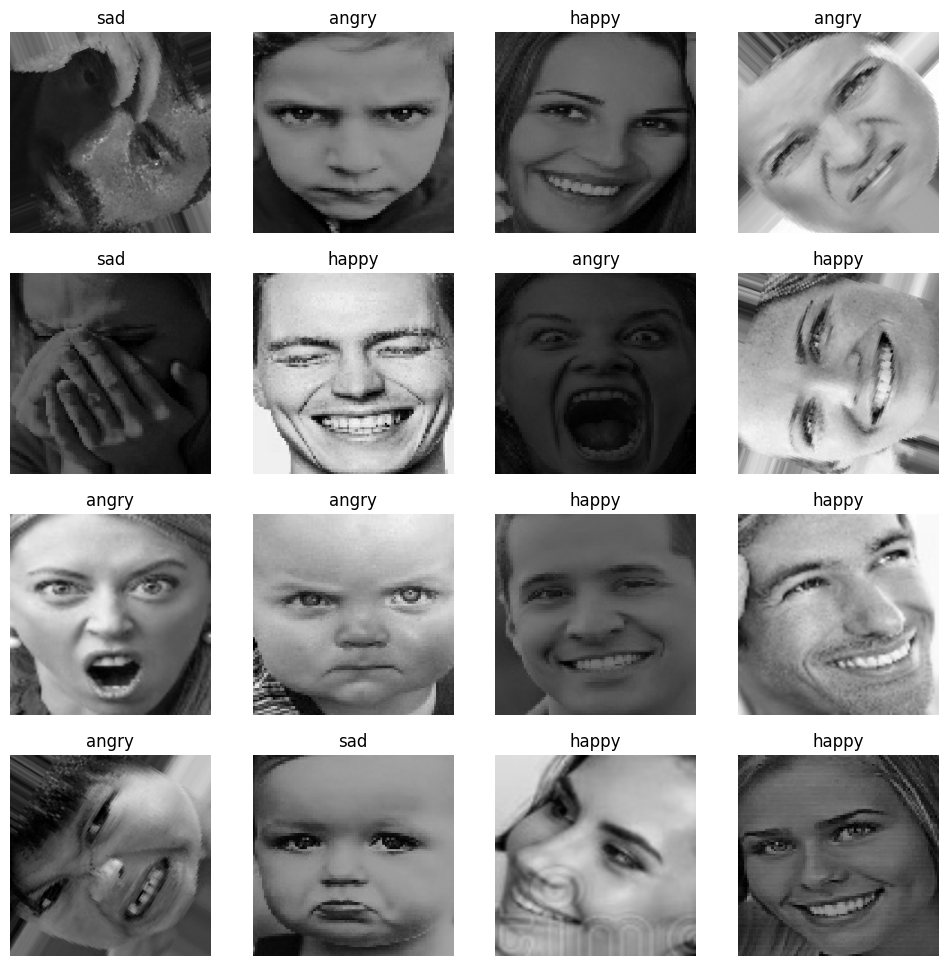

In [70]:
plt.figure(figsize =(12,12))

for images, label in train_dataset.take(1):
  for i in range(16):
    ax = plt.subplot(4,4,i+1)
    plt.imshow(images[i]/255.)
    plt.title(CLASS_NAMES[tf.argmax(label[i], axis =0).numpy()])
    plt.axis("off")

# Data Augmentation

In [111]:
@tf.function
def augment(image, label):
  image, label = resize_rescale(image, label)

  image = tf.image.rot90(image)

  image = tf.image.flip_left_right(image)

  return image, label



In [113]:
class RolNinety(Layer):

  def __init__(self):
    super().__init__()

  @tf.function
  def call(self, image):
    return tf.image.rot90(image)

In [115]:
import tensorflow as tf

augment_layers = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomRotation(factor=(0.25, 0.2501)),
    tf.keras.layers.experimental.preprocessing.RandomFlip(mode='horizontal'),
])

@tf.function
def augment_layer(image, label):
    image = augment_layers(image, training=True)
    image = tf.image.adjust_contrast(image, contrast_factor=0.1)  # Adjust contrast
    return image, label

Dataset Preperation

In [128]:
import tensorflow as tf

# Assuming you have defined `train_dataset` and `augment_layer` function

# Apply data augmentation to the training dataset
training_dataset = (
    train_dataset
    .map(augment_layer, num_parallel_calls=tf.data.AUTOTUNE)
    # .prefetch(tf.data.AUTOTUNE)
)


In [129]:
validation_dataset = (
    val_dataset
    # .prefetch(tf.data.AUTOTUNE)
)

In [130]:
import tensorflow as tf
from tensorflow.keras.layers import Resizing, Rescaling

IM_SIZE = 224  # Replace with your desired image size

resize_rescale_layers = tf.keras.Sequential([
    Resizing(IM_SIZE, IM_SIZE),
    Rescaling(1./255),
])


Modeling

In [131]:
CONFIGURATION = {
    "LEARNING_RATE": 0.001,
    "N_EPOCHS": 20,
    "BATCH_SIZE": 32,
    "DROPOUT_RATE": 0.0,
    "IM_SIZE": 224,
    "REGULARIZATION_RATE": 0.0,
    "N_FILTERS": 6,
    "KERNEL_SIZE": 3,
    "N_STRIDES": 1,
    "POOL_SIZE": 2,
    "N_DENSE_1": 100,
    "N_DENSE_2": 10,
    "NUM_CLASSES": 3
}


In [153]:
lenet_model = tf.keras.Sequential([

    InputLayer(input_shape = (CONFIGURATION["IM_SIZE"],CONFIGURATION["IM_SIZE"],3)),
    Rescaling(1./255, name = "rescaling"),

    Conv2D(filters = CONFIGURATION["N_FILTERS"], kernel_size = CONFIGURATION["KERNEL_SIZE"],
           strides = CONFIGURATION["N_STRIDES"], activation = 'relu',
           kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    MaxPool2D(pool_size = CONFIGURATION["POOL_SIZE"], strides = CONFIGURATION["N_STRIDES"]*2),
    Dropout(rate = CONFIGURATION["DROPOUT_RATE"]),

    Conv2D(filters = CONFIGURATION["N_FILTERS"] *2 +4, kernel_size = CONFIGURATION["KERNEL_SIZE"],
           strides = CONFIGURATION["N_STRIDES"], activation = 'relu',
           kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    MaxPool2D(pool_size = CONFIGURATION["POOL_SIZE"], strides = CONFIGURATION["N_STRIDES"]*2),

    Flatten(),

    Dense(CONFIGURATION["N_DENSE_1"], activation = 'relu', kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
     Dropout(rate = CONFIGURATION["DROPOUT_RATE"]),

     Dense(CONFIGURATION["N_DENSE_2"], activation = 'relu', kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),

       Dense(CONFIGURATION["NUM_CLASSES"], activation = 'sigmoid')

]
)

lenet_model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv2d_18 (Conv2D)          (None, 222, 222, 6)       168       
                                                                 
 batch_normalization_32 (Ba  (None, 222, 222, 6)       24        
 tchNormalization)                                               
                                                                 
 max_pooling2d_18 (MaxPooli  (None, 111, 111, 6)       0         
 ng2D)                                                           
                                                                 
 dropout_16 (Dropout)        (None, 111, 111, 6)       0         
                                                                 
 conv2d_19 (Conv2D)          (None, 109, 109, 16)    

Training

In [154]:
loss_function = CategoricalCrossentropy(from_logits = False)

In [155]:
y_true = [[0,1,0],[0,0,1]]
y_pred = [[0.05,0.05,0], [0.1,0.0,0.1]]
cce = tf.keras.losses.CategoricalCrossentropy()
print(cce(y_true, y_pred).numpy())

0.6931472


In [156]:
metrics = [CategoricalAccuracy(name = "accuracy"),
           TopKCategoricalAccuracy(k=2, name ="top_k_accuracy")]

In [157]:
lenet_model.compile(
    optimizer = Adam(learning_rate = CONFIGURATION['LEARNING_RATE']),
                     loss =loss_function,
                     metrics = ['accuracy'])


In [ ]:
history = lenet_model.fit(
    training_dataset,
    validation_data = validation_dataset,
    epochs =100,
    verbose =1,

)

Epoch 1/100


213/213 [==============================] - 39s 175ms/step - loss: 1.8841 - accuracy: 0.3009 - categorical_crossentropy: 1.8882 - val_loss: 1.4589 - val_accuracy: 0.3218 - val_categorical_crossentropy: 1.4807
Epoch 2/100
213/213 [==============================] - 36s 167ms/step - loss: 1.8440 - accuracy: 0.3127 - categorical_crossentropy: 1.8593 - val_loss: 2.6124 - val_accuracy: 0.3547 - val_categorical_crossentropy: 2.6788
Epoch 3/100
213/213 [==============================] - 38s 175ms/step - loss: 1.8658 - accuracy: 0.3074 - categorical_crossentropy: 1.8759 - val_loss: 6.6931 - val_accuracy: 0.3657 - val_categorical_crossentropy: 6.6642
Epoch 4/100
213/213 [==============================] - 38s 178ms/step - loss: 1.8552 - accuracy: 0.3124 - categorical_crossentropy: 1.8623 - val_loss: 10.4859 - val_accuracy: 0.3736 - val_categorical_crossentropy: 10.2531
Epoch 5/100
213/213 [==============================] - 37s 171ms/step - loss: 1.8929 - accuracy: 0.3002 - categorical_crossentropy

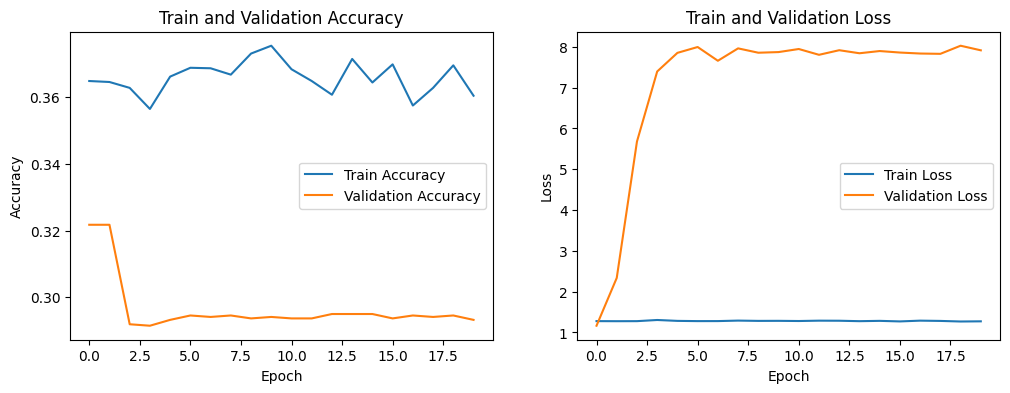

In [138]:
# Plotting accuracy and loss
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Train and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Train and Validation Loss')

plt.show()

In [139]:
# Predict probabilities for validation data
val_probs = lenet_model.predict(val_dataset)
val_labels = np.concatenate([y for x, y in val_dataset], axis=0)

72/72 [==============================] - 3s 38ms/step


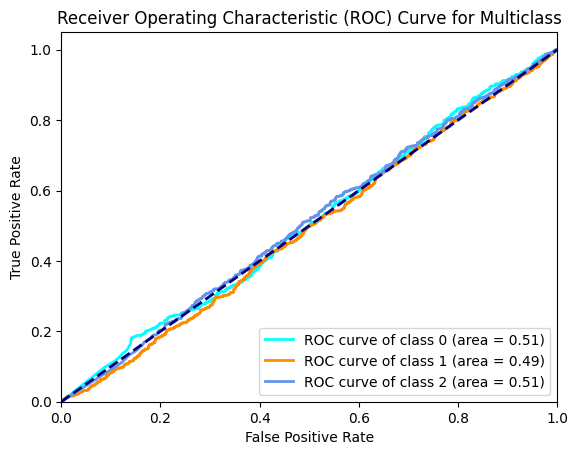

In [140]:
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize

# Assuming val_labels is one-hot encoded and val_probs contains the predicted probabilities for each class
n_classes = val_labels.shape[1]

# Binarize the labels for one-vs-rest ROC calculation
val_labels_binary = label_binarize(val_labels, classes=np.arange(n_classes))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(val_labels_binary[:, i], val_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure()
colors = ['aqua', 'darkorange', 'cornflowerblue', 'darkgreen', 'purple']  # Add more colors if needed

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of class {i} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Multiclass')
plt.legend(loc='lower right')
plt.show()


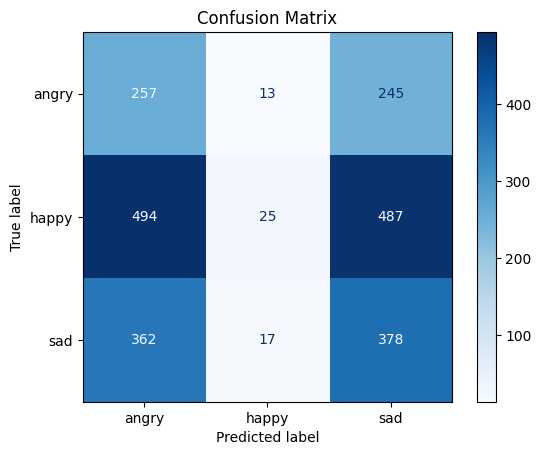

[[257  13 245]
 [494  25 487]
 [362  17 378]]


In [141]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Assuming val_labels is one-hot encoded and val_probs contains the predicted probabilities for each class
# Convert one-hot encoded labels to single class labels
val_labels_single = np.argmax(val_labels, axis=1)

# Convert probabilities to predicted class labels
val_preds_single = np.argmax(val_probs, axis=1)

# Calculate confusion matrix
cm = confusion_matrix(val_labels_single, val_preds_single)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CLASS_NAMES)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

print(cm)


Classification Report
              precision    recall  f1-score   support

       angry       0.23      0.50      0.32       515
       happy       0.45      0.02      0.05      1006
         sad       0.34      0.50      0.40       757

    accuracy                           0.29      2278
   macro avg       0.34      0.34      0.26      2278
weighted avg       0.37      0.29      0.23      2278



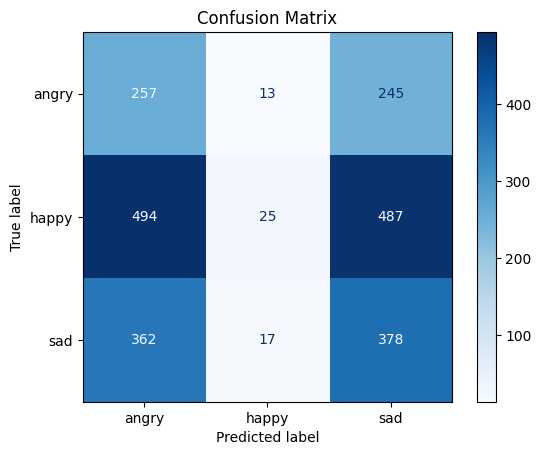

In [142]:
import numpy as np
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Assuming val_labels is one-hot encoded and val_probs contains the predicted probabilities for each class
# Convert one-hot encoded labels to single class labels
val_labels_single = np.argmax(val_labels, axis=1)

# Convert probabilities to predicted class labels
val_preds_single = np.argmax(val_probs, axis=1)

# Calculate and print the classification report
print('Classification Report')
print(classification_report(val_labels_single, val_preds_single, target_names=CLASS_NAMES))

# Calculate and display the confusion matrix
cm = confusion_matrix(val_labels_single, val_preds_single)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CLASS_NAMES)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


Evaluation

In [143]:
lenet_model.evaluate(validation_dataset)

72/72 [==============================] - 4s 52ms/step - loss: 7.8604 - accuracy: 0.2932 - categorical_crossentropy: 7.8775


[7.860432147979736, 0.29323968291282654, 7.877526760101318]

# Testing

In [107]:
 test_image = cv2.imread("/content/dataset/Emotions Dataset/Emotions Dataset/test/angry/101071.jpg_rotation_1.jpg")

 im = tf.constant(test_image, dtype = tf.float32)

 print(im.shape)

(224, 224, 3)


1/1 [==============================] - 0s 18ms/step


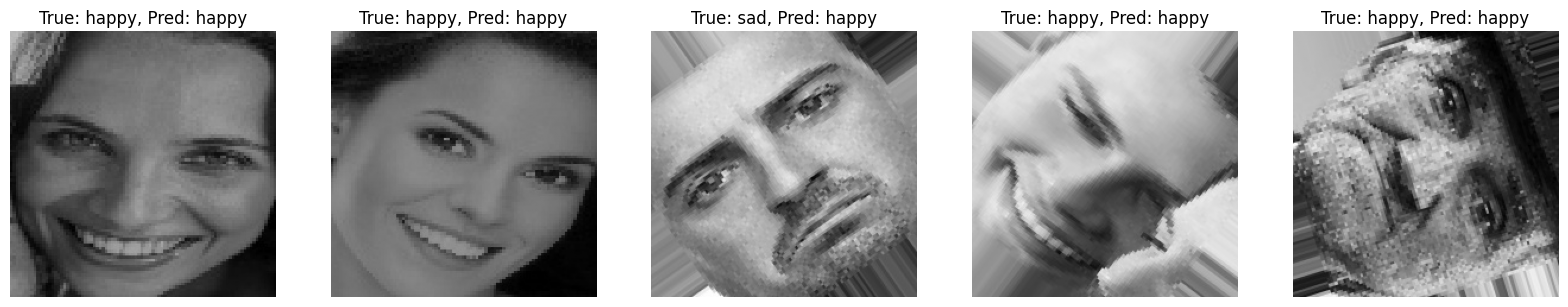

In [144]:
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import os
import random

# Function to load and preprocess a single image
def load_and_preprocess_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
    image = cv2.resize(image, (224, 224))  # Resize to match the model input size
    image = image / 255.0  # Normalize to [0, 1]
    return image

# Function to get random images from a directory
def get_random_images_from_directory(directory, num_images):
    all_image_paths = []
    class_names = sorted(os.listdir(directory))
    for class_name in class_names:
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            image_paths = [os.path.join(class_path, img) for img in os.listdir(class_path) if img.endswith(('.png', '.jpg', '.jpeg'))]
            all_image_paths.extend(image_paths)
    random_image_paths = random.sample(all_image_paths, num_images)
    return random_image_paths, class_names

# Directory of test images
test_directory = "/content/dataset/Emotions Dataset/Emotions Dataset/test"

# Get random images and class names
random_image_paths, class_names = get_random_images_from_directory(test_directory, 5)

# Plot predictions
plt.figure(figsize=(20, 20))

for i, image_path in enumerate(random_image_paths):
    image = load_and_preprocess_image(image_path)
    image_tensor = tf.constant(image, dtype=tf.float32)
    image_tensor = tf.expand_dims(image_tensor, axis=0)  # Add batch dimension

    # Predict the class of the image
    prediction = lenet_model.predict(image_tensor)[0][0]
    predicted_class = class_names[int(prediction > 0.5)]

    # Actual class
    true_class = os.path.basename(os.path.dirname(image_path))

    # Display the image
    plt.subplot(5, 5, i + 1)
    plt.imshow(image)
    plt.title(f"True: {true_class}, Pred: {predicted_class}")
    plt.axis("off")

plt.show()
